In [1]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')

import RS_SMA100B
from Card_Class import *


import FSL_0010

fsl = FSL_0010.FSL10_synthesizer(device_address='COM31')

In [18]:
fsl.get_temp()

'51.4 °C'

In [27]:
# SMA100B
ip              = '192.168.40.15'
sGen            = RS_SMA100B.SMA100B(ip)
sGen.reset()
sGen.clear()
sGen.RF_freq(1.08E9)
sGen.RF_lvl_ampl(-5)
sGen.RF_state(1)







# senza attenuazione: -40dBm
#
# Model No.	    Range	            Resolution	    Switching Speed	    RF Output	        10 kHz Phase Noise	    Spurious
# FSL-0010	    0.65 to 10 GHz	    0.001 Hz	    100 μs	            +15 dBm min.	    -117 dBc/Hz @ 10 GHz	-70 dBc

SMA100B: Connection successful!


'RF set to ON'

In [28]:
sGen.RF_state(0)
fsl.set_output('OFF')

'RF set to OFF'

In [29]:
ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

pulse_freq      = 1.08e9
amplitude       = -5                          # Set the amplitude of the signal in dBm
sample_rate     = 250e6 # Maximum Value: 250.0e6
pulse_width     = 3e-6   # min 5ns                             
pulse_delay     = 0
pulse_period    = 5e-6   # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')
sGen.RF_freq(pulse_freq)
sGen.RF_lvl_ampl(amplitude)


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate # Maximum Value: 250.0e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)


# FSL-0010
fsl.set_frequency(1) # GHz
fsl.set_output('ON')

SMA100B: Connection successful!
5170R: Available communication!


'RF set to ON'

In [30]:
sGen.pul_state(1)
sGen.RF_state(1)
time.sleep(0.1)
waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
sGen.pul_state(0)
sGen.RF_state(0)
data = waveforms[0].samples.tolist()

AcquisitionStatus.COMPLETE


In [13]:
# with ni.Session("PXI1Slot3") as session: # Name of the device
#     session.reset_with_defaults()
#     session.channels[0].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # I
#     # session.channels[1].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # Q
#     session.configure_horizontal_timing(
#         min_sample_rate     = 250e6, 
#         min_num_pts         = int(1000), 
#         ref_position        = 0, 
#         num_records         = 1, 
#         enforce_realtime    = True
#         )

#     session.configure_trigger_digital(
#         trigger_source      = 'VAL_PFI_0', 
#         slope               = ni.TriggerSlope.POSITIVE, 
#         holdoff             = 0, 
#         delay               = 0
#         )

#     with session.initiate():
#         waveforms = session.channels[0, 1].fetch()
#     for wfm in waveforms:
#         print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))

# fsl.set_output('OFF')

Channel 0, record 0 samples acquired: 1,000

Channel 1, record 0 samples acquired: 1,000



'RF set to OFF'

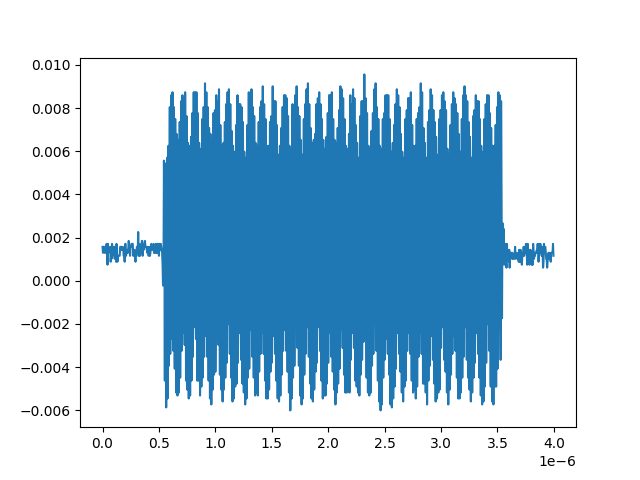

In [33]:
a = waveforms[0].samples.tolist()
# b = waveforms[1].samples.tolist()
plt.figure()
plt.plot(np.arange(len(a))/250e6, a)#20*np.log10(np.array(a)**2+np.array(b)**2))


In [37]:
def weight_factor (ft, range_mask):
    # tot_int = np.trapz(ft)
    tot_int = np.sum(ft)
    ft[~range_mask] = 0
    # portion = np.trapz(ft)
    portion = np.sum(ft)

    return tot_int/portion

def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
    N = len(y)
    T = 1/sample_rate
    FT = np.fft.fft(y)
    PHI = np.unwrap(np.angle(FT))

    x = np.arange(len(y))/sample_rate
    freqs = np.fft.fftfreq(N,T) 
    offset = 5e6
    mask = (freqs < (freq+offset)) & (freqs > (freq-offset))
    maxx = np.max(FT[mask])
    phi = PHI[np.where(FT == maxx)]



    range = .3e8
    FT = np.fft.fft(y * np.cos(x*freq*2*np.pi + phi))
    # print(FT)
    freqs = np.fft.fftfreq(N,T)  
    region_mask = (freqs >= -range) & (freqs <= range)
    x_region = FT.copy()
    x_region[~region_mask] = 0

    # IFT = np.fft.ifft(x_region*2)
    w_f = weight_factor (np.abs(FT), region_mask)
    print(w_f)
    IFT = np.fft.ifft(x_region*w_f)
    IFT_2 = np.fft.ifft(x_region*2)
    # average = np.average(np.abs(IFT[300:500]))


    AB_IFT = np.abs(IFT)
    AB_IFT_2 = np.abs(IFT_2)
    indices = find_peaks(AB_IFT, height= np.average(AB_IFT))
    idx = indices[0]
    offset = 10
    idx = idx[offset:-offset]
    average = np.average(AB_IFT[idx])
    print(len(AB_IFT))

    if toggle_plot:
        # plt.clf()
        
        # plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.plot(freqs,np.abs(FT))
        plt.subplot(1,2,2)
        plt.plot(np.arange(len(y))*T, AB_IFT_2, linewidth = 3, color = 'red')
        # plt.plot(AB_IFT_2)
        # plt.scatter(np.arange(len(AB_IFT))[idx]*T,AB_IFT[idx], color = 'orange')
        plt.draw()

In [35]:
data_fft(a, 80e6, sample_rate, True)

NameError: name 'x' is not defined